# A frequentist tutorial to limit setting

_by @jadevrie, with lessons learned from_  
https://arxiv.org/abs/physics/9711021   
https://phas.ubc.ca/~oser/p509/Lec_16.pdf / https://www.pas.rochester.edu/~sybenzvi/courses/phy403/2015s/p403_19_intervals.pdf  
https://www.phys.ksu.edu/personal/gahs/phys707-prog/ClassDh8.html  

In [1]:
import ROOT as R

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

from tqdm.notebook import tqdm
import time

R.RooMsgService.instance().setGlobalKillBelow(R.RooFit.WARNING) # suppress INFO & PROGRESS streams

Welcome to JupyROOT 6.28/04


## Let's build a dataset and play around with it

### Define our model

In [2]:
# independent var
x_window = [4700, 5700]
x = R.RooRealVar("x", "Mass", *x_window, "[MeV/c^{2}]")

# signal
mean_start = 5200
width_start = 25
mean = R.RooRealVar("mean", "mean", mean_start, 5195, 5205)
width = R.RooRealVar("width", "width", width_start, 22, 28)
sig_pdf = R.RooGaussian("sig_pdf", "signal PDF", x, mean, width)

# background
expo_c_start = -0.001
expo_c = R.RooRealVar("expo_c", "Expo const", expo_c_start, -0.01, 0.)
bkg_pdf = R.RooExponential("bkg_pdf", "background PDF", x, expo_c)

# combined shape
N_sig_start =  100.
N_bkg_start = 1000.
N_sig = R.RooRealVar("N_sig", "N signal events", N_sig_start, 0., 1e5)
N_bkg = R.RooRealVar("N_bkg", "N backgr events", N_bkg_start, 0., 1e8)
pdf = R.RooAddPdf("pdf", "full PDF", R.RooArgList(sig_pdf, bkg_pdf), R.RooArgList(N_sig, N_bkg))

In [3]:
def reset_pdf_vars( N_bkg_start = N_bkg_start, expo_c_start = expo_c_start ) :
    mean.setVal(mean_start)
    width.setVal(width_start)
    expo_c.setVal(expo_c_start)
    N_sig.setVal(N_sig_start)
    N_bkg.setVal(N_bkg_start)

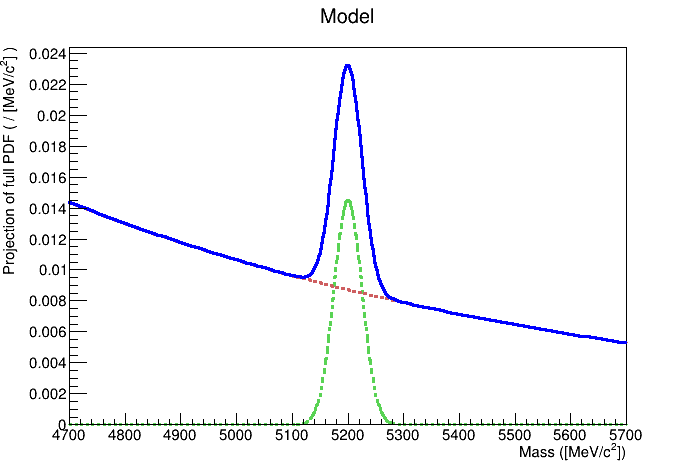

In [4]:
# Visualize it

c1 = R.TCanvas("c1")
frame = x.frame(R.RooFit.Title("Model"))

def drawPDF() :
    pdf.plotOn(frame, R.RooFit.Components("sig_pdf"), R.RooFit.LineColor(8),  R.RooFit.LineStyle(2) )
    pdf.plotOn(frame, R.RooFit.Components("bkg_pdf"), R.RooFit.LineColor(46), R.RooFit.LineStyle(2) )
    pdf.plotOn(frame)
    pdf.SetTitle("Model")
    frame.Draw()
    c1.Update()
    c1.Draw()
    
drawPDF()

### Generate some toy data

In [5]:
Nevents = 10000
data = pdf.generate(x, Nevents)

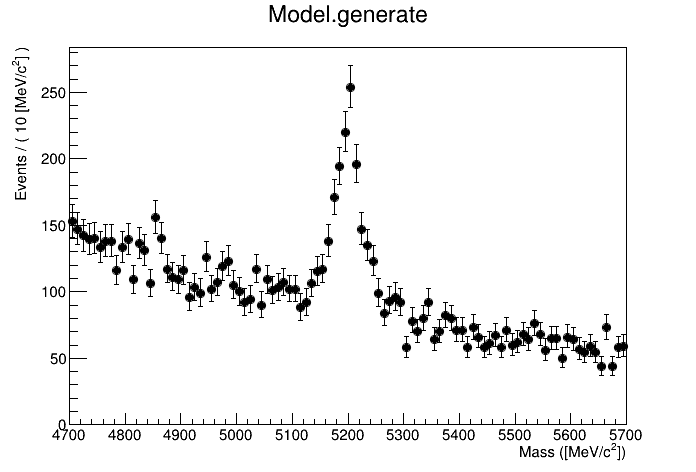

In [6]:
frame = x.frame(R.RooFit.Title("Model.generate"))

def drawData(data) :
    data.plotOn(frame)
    frame.Draw()
    c1.Update()
    c1.Draw()
    
drawData(data)

### Fit the toy data

In [7]:
fitresult = pdf.fitTo(data, R.RooFit.PrintLevel(-1), R.RooFit.Save())

fitresult.Print()


  RooFitResult: minimized FCN value: -13666.7, estimated distance to minimum: 2.88451e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                 N_bkg    9.1440e+03 +/-  1.03e+02
                 N_sig    8.5590e+02 +/-  4.90e+01
                expo_c   -9.8660e-04 +/-  3.74e-05
                  mean    5.2002e+03 +/-  1.50e+00
                 width    2.4640e+01 +/-  1.55e+00



N_sig:   855.90 +-   49.04
N_bkg:  9143.96 +-  103.40
mean :  5200.22 +-    1.50
width:    24.64 +-    1.55

chi2/ndf: 1.00
-log(L) at minimum: -13666.66



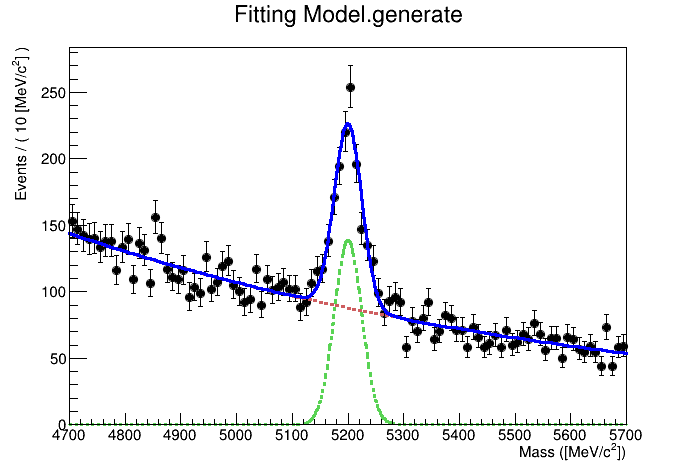

In [8]:
# Show fit result
        
frame = x.frame(R.RooFit.Title("Fitting Model.generate"))
drawData(data)
drawPDF()

for param in [N_sig, N_bkg, mean, width] :
    print("{:5}: {:8.2f} +- {:7.2f}".format(param.GetName(), param.getVal(), param.getError()))

print("\nchi2/ndf: {:.2f}".format(frame.chiSquare(nFitParam = 5)))
print("-log(L) at minimum: {:.2f}\n".format(fitresult.minNll()))

### How does the error scale with the amount of data?

Let's now create increasingly large generated datsets from our model, and see how the fitted yield behaves.

In [9]:
def scan_Nevents( Nevents_array ) :
    Nsig_val_array = []
    Nsig_err_array = []
    failed = []
    
    for Nevents in tqdm(Nevents_array) :
        
        reset_pdf_vars()
        data = pdf.generate(x, Nevents)
        fitresult = pdf.fitTo(data, R.RooFit.PrintLevel(-1), R.RooFit.Save())
        
        if(fitresult.status() > 0) : 
            failed += [Nevents]
            continue
            
        Nsig_val_array += [N_sig.getVal()]
        Nsig_err_array += [N_sig.getError()]
    
    # Deal with failed fits
    if(len(failed) > 0) : print("# failed fits: {0}".format(len(failed)))
    Nevents_array = list(set(Nevents_array) - set(failed))
    Nevents_array.sort()
    return Nevents_array, Nsig_val_array, Nsig_err_array

In [10]:
R.RooRandom.randomGenerator().SetSeed(4) # for guaranteed demo results 
Nevents_array = range(200, 4000, 100)
Nevents_array, Nsig_val_array, Nsig_err_array = scan_Nevents( Nevents_array )

  0%|          | 0/38 [00:00<?, ?it/s]

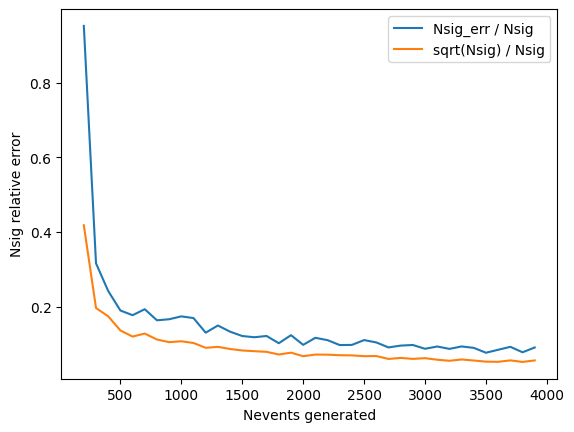

In [11]:
# Absolute error
#plt.plot(Nevents_array, Nsig_err_array)
#plt.plot(Nevents_array, [math.sqrt(x) for x in Nsig_val_array])
#plt.legend(["Nsig_err","sqrt(Nsig)"])
#plt.ylabel("Nsig abs error")

# Relative error
plt.plot(Nevents_array, [i/j for i,j in zip(Nsig_err_array, Nsig_val_array)])
plt.plot(Nevents_array, [math.sqrt(x)/x for x in Nsig_val_array])
plt.legend(["Nsig_err / Nsig","sqrt(Nsig) / Nsig"])
plt.ylabel("Nsig relative error")

plt.xlabel("Nevents generated")
plt.show()

You can see that the relative error goes down with more data - but remains larger than the Poissonian sqrt(N) law.  
Can you understand why?

We can also plot the 'significance' (number of times the error away from 0) of the as a function of the amount of data

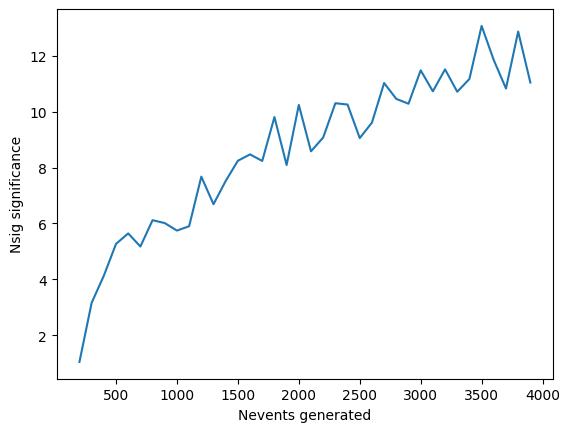

In [12]:
# Significance

pull_array = [(Nsig_val - 0.) / Nsig_err for Nsig_val, Nsig_err in zip(Nsig_val_array, Nsig_err_array)]
plt.plot(Nevents_array, pull_array)

plt.ylabel("Nsig significance")
plt.xlabel("Nevents generated")
plt.show()

You can see that the significance increases the larger the dataset.  
But what do you do when the significance $< 5 \sigma$? You use your information on your experimental sensitivity to <u>set a limit</u>:  
_"the amount of events certainly does not _exceed_ X, or we would have seen it."_  
Let's see how one could approach that.

# Now let's make our 'real' small dataset

Maybe pick a number that results in around 3 sigma significance above, for the limit-setting story.

In [13]:
# Let's say we've observed a few events in total, in our experiment
Nevents = 300

reset_pdf_vars()

# Get the true model value - not necessary for the process, just informative
Nsig_true = N_sig.getVal() / (N_sig.getVal() + N_bkg.getVal()) * Nevents
print("True Nsig = {:.1f}".format(Nsig_true))

# Generate the dataset
real_data = pdf.generate(x, Nevents)
print("Events in unblinded dataset: {}".format(real_data.sumEntries()))

# Blind the signal region
blinding_window = [5100, 5300]
real_data_blinded = R.RooDataSet("real_data_blinded", "Blinded data", real_data, R.RooArgSet(x), "x < {} || x > {}".format(*blinding_window) )
print("Events in blinded dataset:   {}".format(real_data_blinded.sumEntries()))



True Nsig = 27.3
Events in unblinded dataset: 300.0
Events in blinded dataset:   222.0


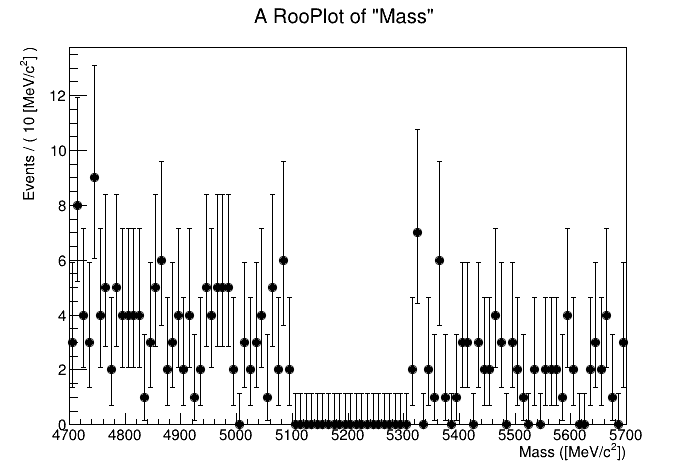

In [14]:
frame = x.frame()
#drawData(real_data)  # <-- this would be unblinding!
drawData(real_data_blinded)

## We can fit the sidebands

(without unblinding the data)

In [15]:
# Define sideband ranges
x.setRange("FULL",  x_window[0], x_window[1])
x.setRange("LEFT",  x_window[0], blinding_window[0])
x.setRange("RIGHT", blinding_window[1], x_window[1])

In [16]:
# Don't fit the signal shape
N_sig.setVal(0)
N_sig.setConstant(True)
mean.setConstant(True)
width.setConstant(True)

In [17]:
fitresult = pdf.fitTo(real_data_blinded, R.RooFit.Range("LEFT,RIGHT"), R.RooFit.PrintLevel(-1), R.RooFit.Save() )
fitresult.Print()  # <-- Note: extended PDF yield values are over the full range.


  RooFitResult: minimized FCN value: 493.45, estimated distance to minimum: 6.12691e-08
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                 N_bkg    2.7431e+02 +/-  1.85e+01
                expo_c   -1.0955e-03 +/-  2.19e-04



In [18]:
# Save the 'true' fitted values on the 'real' dataset
N_bkg_val_true = N_bkg.getVal()
exp_c_val_true = expo_c.getVal()

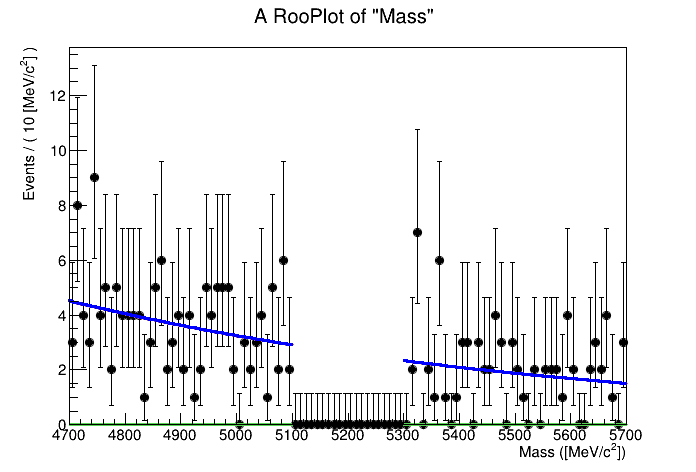

In [19]:
frame = x.frame()
drawData(real_data_blinded)
drawPDF()

## We can now make some sensitivity estimates

In the following toys, our _true_ (here: 'generated') value is `Nsig_gen`.  
Our _estimator_ for this quantity is the fitted value, `N_sig`.  

In order to determine confidence intervals and p-values, we need a way to construct the underlying PDF of our estimator.  
Approaching this as a frequentist, we consider the measured data we observe as some random sample of a true underlying model (which we'd observe with infinite statistics).  
Fluctuating our observed sidebands from 'data' at a certain fixed `Nsig_gen` we aim to get a sense of the underlying distribution of our estimator.  

For illustration, we'll first look at the case `Nsig_gen = 0` alone.

In [20]:
# To generate datasets we need the full model again
N_sig.setConstant(False)
mean.setConstant(True)  # Assume calibrated & fixed
width.setConstant(True) # ''

In [21]:
# Allow for small negative signal yields in the signal PDF. 
# RooFit does not like parts of the _whole_ PDF becoming negative, so fits might fail at low yields.
#R.RooMsgService.instance().setGlobalKillBelow(R.RooFit.ERROR) # Disable ERROR printouts for struggling fits in the notebook
N_sig.setMin(-15)

In [22]:
def generate_and_fit( Nsig_gen ) :
    
    # set values for PDF parameters
    reset_pdf_vars() 
    N_bkg.setVal( N_bkg_val_true )  # from sideband fit
    expo_c.setVal( exp_c_val_true ) #  ''
    N_sig.setVal( Nsig_gen )        # set for generation

    # Generate signal and background
    toydata = pdf.generate(x, N_bkg_val_true + Nsig_gen)
    
    # Fit
    N_sig.setVal(0) 
    fitresult = pdf.fitTo(toydata, R.RooFit.Range("FULL"), R.RooFit.PrintLevel(-1), R.RooFit.Save())
    #fitresult.Print()
    
    # Draw
    #frame = x.frame()
    #drawData(toydata)
    #drawPDF()
    
    return fitresult, N_sig.getVal()

In [23]:
def loop_generate_and_fit( Nsig_gen, N_iters, leavebar=True ) :
    Nsig_val_array = []
    Nfailed = 0

    for i in tqdm(range(N_iters), leave=leavebar) :
        fitresult, Nsig_val = generate_and_fit( Nsig_gen )
    
        if(fitresult.status() > 0) : 
            Nfailed += 1
            continue
        
        Nsig_val_array += [Nsig_val]
    
    if(Nfailed > 0) : print("# failed fits: {0}".format(Nfailed))
    return Nsig_val_array

In [24]:
# Run toys with Nsig_gen=0, but background fluctuating

Nsig_gen = 0
N_iters = 1000
Nsig_val_array = loop_generate_and_fit( Nsig_gen, N_iters )

  0%|          | 0/1000 [00:00<?, ?it/s]

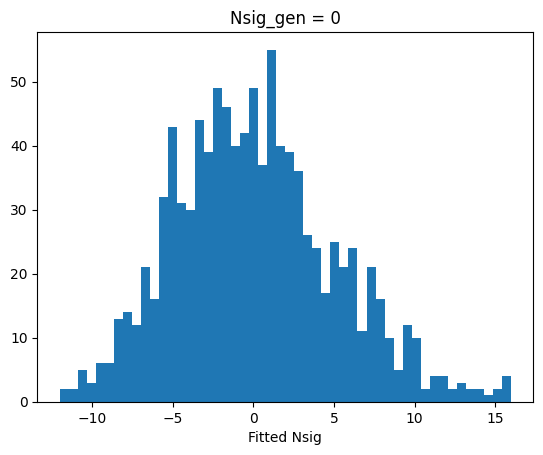

In [25]:
# Make histogram

#plt.hist(Nsig_val_array, bins=50)
counts, bins = np.histogram(Nsig_val_array, bins=50)
plt.hist(bins[:-1], bins, weights=counts)
plt.title("Nsig_gen = {}".format(Nsig_gen))
plt.xlabel("Fitted Nsig");

If the fit is unbiased, this should be somewhat like a Gaussian centered around `Nsig_gen`.

## Find the confidence intervals

For the case `Nsig_gen = 0`, we've just generated a distribution for our 'test statistic' / 'estimator' `N_sig` (aka the fitted value).  
Now that we know how this value is distributed, we can use this to calculate the thresholds values for the `confidence level`.  

In [26]:
def makeCDFfromHist( bins, counts, plot=False ):
    CDF = np.cumsum(counts)

    # Normalize
    CDF = [cdf/CDF[-1] for cdf in CDF]
    if(plot) : plt.plot(bins[:-1],CDF)

    # Interpolate for smooth solving
    CDFint = sp.interpolate.CubicSpline(bins[:-1],CDF)
    if(plot) : plt.plot(bins[:-1], CDFint(bins[:-1]));
    
    if(plot) : 
        plt.title("Nsig_gen = {}".format(Nsig_gen))
        plt.xlabel("Fitted Nsig");
        plt.ylabel("CDF");
        
    return CDFint

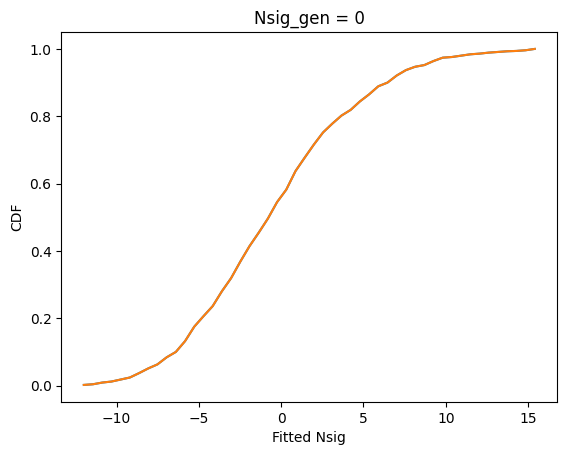

In [27]:
# Calculate cumulative
CDFint = makeCDFfromHist(bins, counts, plot=True)

In [28]:
# helper function to pick out the proper solutions from CDF.solve
def findProperCDFSolve( sollist, absmin = -12., tolerancefactor=1.2 ) :
    #print(sollist)
    
    solutions = [sollist[0][0]]
    if(len(sollist[0]) > 1 and solutions[0] < absmin) : 
       solutions[0] = sollist[0][1]
       
    for isol in range(len(sollist)-1) :
       sol = sollist[isol+1]
    
       if len(sol)==0 : 
            print("WARNING: emtpy solution list found for point {}, setting to -20.".format(isol))
            solutions += [-20.]
            continue
    
       if(len(sol) == 1 or sol[0] > solutions[isol] * tolerancefactor) : 
           solutions += [sol[0]]
       else : 
           solutions += [sol[1]]
    
    #print(solutions)
    return solutions

### 1-sided confidence interval for limit

For a one-sided `CL` we can simply integrate the left side of the distribution from the toys up to the `CL` value.  
Do you think it is a problem that most of the distribution lies in the unphysical `Nsig` region? 

In [29]:
CLval = 0.90

In [30]:
# Find Nsig value at CL
Nsig_limit = findProperCDFSolve( [CDFint.solve(CLval)] )[0]

print("Expected limit when Nsig_gen = 0: Nsig < {:2.2f} (@ {:2.0f}% CL)".format(Nsig_limit, CLval*100))

Expected limit when Nsig_gen = 0: Nsig < 6.46 (@ 90% CL)


### 2-sided confidence interval for observation

For a 2-sided `CL` we have to make a choice how to define the region, especially when it is asymetrically distributed. Do we:
- Start from the left and right, and integrate towards the middle up to where we reach `(1-CL)/2` ?
- Start from the `mean` / `median` / `mode` and integrate left and right until we reach `CL/2` ?
- ...?

The resulting expected value and CL range can reach into the unphysical region - is that a problem?

In [31]:
# Find Nsig value around peak
Nsig_central   = findProperCDFSolve( [CDFint.solve(0.5)] )[0] # Median
Nsig_lowerband = findProperCDFSolve( [CDFint.solve((1-CLval)/2)] )[0]
Nsig_upperband = findProperCDFSolve( [CDFint.solve((1-CLval)/2 + CLval)] )[0]

print("Expected 'observation' with Nsig_gen = 0: Nsig = {:.2f} [{:.2f},{:.2f}] (@ {:2.0f}% CL)".format(Nsig_central, Nsig_lowerband, Nsig_upperband, CLval*100))

Expected 'observation' with Nsig_gen = 0: Nsig = -0.76 [-8.12,8.51] (@ 90% CL)


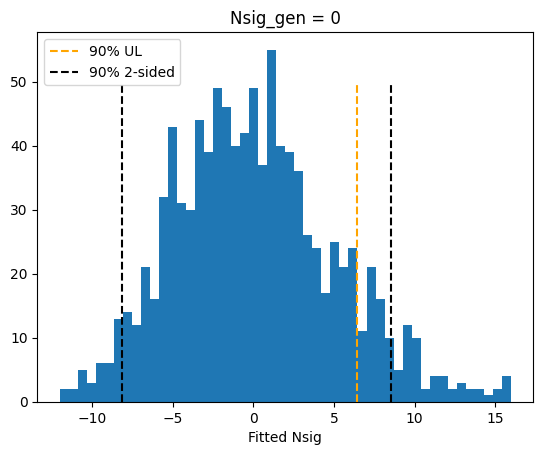

In [32]:
# Draw the distribution again, with our found CL points

plt.hist(bins[:-1], bins, weights=counts)
plt.title("Nsig_gen = {}".format(Nsig_gen))
plt.xlabel("Fitted Nsig");

plt.plot((Nsig_limit, Nsig_limit), (0, 50), scaley = False, color="orange", linestyle="dashed")
plt.plot((Nsig_lowerband, Nsig_lowerband), (0, 50), scaley = False, color="black", linestyle="dashed")
plt.plot((Nsig_upperband, Nsig_upperband), (0, 50), scaley = False, color="black", linestyle="dashed")

plt.legend(["90% UL", "90% 2-sided"], loc="upper left");

In case of an observation, the region between the black lines would be the confidence band of our estimator.  
Otherwise, everything above the yellow line you'd want to call 'excluded'.  
Both reach into the unphysical region.  

But before we deal with that, hang on. Our story above is incomplete.  

## Confidence belts

Before we continue - there is one thing we did not take into account yet.  
Other values of `Nsig_gen` can also result in similar values for the fitted `N_sig`. We need to take that into account.  
Let's repeat the above exercise varying `Nsig_gen`, and construct the so-called `Neyman confidence belts`.

In [33]:
N_iters = 500
Nsig_gen_range = range(-5, 30, 1) 
# for good coverage, include negative signal Nsig_gen (could contribute to fitted Nsig = 0 after all)

CLvals = [0.5, 0.90, 0.95, (1-0.90)/2, 0.90 + (1-0.90)/2, (1-0.95)/2, 0.95 + (1-0.95)/2]
CLvals_solutions = [ [] for _ in range(len(CLvals)) ]

for Nsig_gen in tqdm(Nsig_gen_range) :
    
    # run toys
    Nsig_val_array = loop_generate_and_fit( Nsig_gen, N_iters, leavebar=False )
    
    # make histogram of toy
    counts, bins = np.histogram(Nsig_val_array, bins=50)
    CDFint = makeCDFfromHist( bins, counts )

    # find all the x-axis values at the CLval integrals
    for iCL in range(len(CLvals)) :
        CLvals_solutions[iCL] += [ CDFint.solve( CLvals[iCL] ) ]

    #Nsig_mean = np.mean(Nsig_val_array)
    #Nsig_stdev = np.std(Nsig_val_array)


# pick out the 'right' solutions from solve
for isol in range(len(CLvals)) :
    CLvals_solutions[isol] = findProperCDFSolve( CLvals_solutions[isol] )
    

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

### 2-sided confidence belts

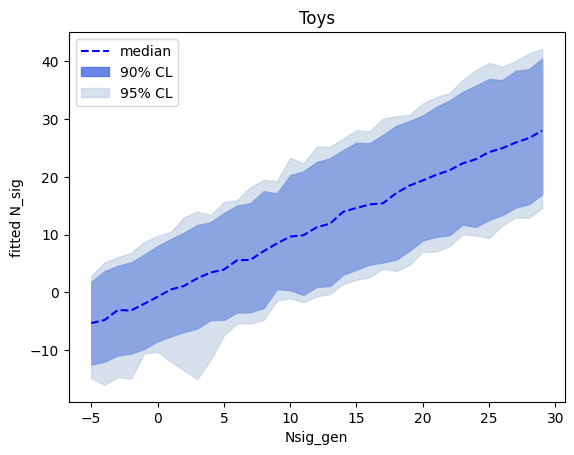

In [34]:
plt.plot(Nsig_gen_range, CLvals_solutions[0], color="blue", linestyle="dashed")
plt.fill_between(Nsig_gen_range, CLvals_solutions[3], CLvals_solutions[4], alpha=0.8, color = "royalblue")
plt.fill_between(Nsig_gen_range, CLvals_solutions[5], CLvals_solutions[6], alpha=0.5, color = "lightsteelblue")

plt.title("Toys")
plt.xlabel("Nsig_gen")
plt.ylabel("fitted N_sig")
plt.legend(["median", "90% CL", "95% CL"], loc="upper left")
plt.show()

The following statements can be made about this plot:
- There seems to be little bias in the fit, as the median line is roughly diagonal.
- Given a fitted result of e.g. `10`, the 68% CL belt maps back to a 'true' region of `Nsig_gen` $\subset$ [4,17] (yellow lines in example below).

Frequentists can only make statements about the probability of observing _this_ data (or getting _this value_ of the estimator), given a true model value. That's how we generated this in the first place.  
Here the confidence interval _is_ the coverage: _"Given a true value of `Nsig_gen = 10` there is a 68% chance that the observed `N_sig` falls within the green lines [4,16]"_.  
With these Neyman confidence belts people _do_ try to <u>turn this statement around</u>, and say something about the true model value given our observation. But we have to be careful.

<div>
<img src="./CIexample.jpg" width="500"/>
</div>

Note that for low fitted values of `N_sig` the confidence belts cover negative values for the true parameter - which we know is unphysical.  
E.g. cutting off at `Nsig_gen > 0`, this means that the integral covered by the physical range is less than the stated CL, thus the _coverage_ is bad. <u>What to do?</u>

### One-sided confidence belts

Now that the mandatory discussion on interpretation is out of the way, let's focus again on limit setting.  
Fortunately we've saved the 90% CL upper limits in the loop as well, let's visualize them.

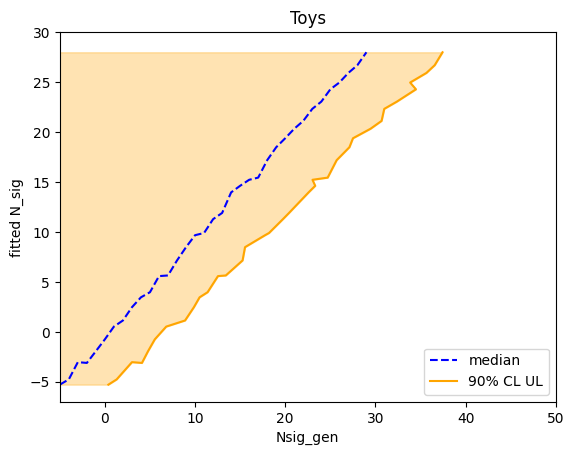

In [35]:
plt.plot(Nsig_gen_range, CLvals_solutions[0], color="blue", linestyle="dashed")

plt.plot(CLvals_solutions[1], CLvals_solutions[0], color="orange")
plt.fill_betweenx(CLvals_solutions[0], [-5]*len(Nsig_gen_range), CLvals_solutions[1], alpha=0.3, color = "orange")

plt.ylim(-7,30)
plt.xlim(-5,50)

plt.title("Toys")
plt.xlabel("Nsig_gen")
plt.ylabel("fitted N_sig")
plt.legend(["median","{:.0f}% CL UL".format(100*CLval)], loc="lower right")
plt.show()

We want to use this result to make statements such as  
_"When observing `N_sig = 10`, there is a 90% chance the true value lies in the range [0,18]"_ (or a 10% chance it lies above 18).  

But what happens when we would fit an 'unphysical' `N_sig = -4`? The belt is tiny, the limit very strong (let's say [0, 0.1]).  
Would that honestly mean there is a 90% chance for the true value to be in that range?  
<b>No</b>, as frequentists we made an interpretation mistake - it probably just means that we <u>observed a measurement</u> that does not include the true value (remember - <u>the chance is 10%!</u>).  

Even worse, what if we observe `N_sig = -6`? The confidence belt is empty, the coverage is 0. Are all values really ruled out by the measurement?  
Of course not. We are limited by our naive frequentist interpretation here - we're just observing a 10% outcome of nature that falls outside the CL.  
But can we improve on our method? For that we should revisit how to count events to include in our belts.  

--> One solution is related to normalisation. The probability to observe exactly `0` events when `Nsig_gen = 10` is small on an absolute scale,  
    But the chance to observe 0 when `Nsig_gen = 0` when there is some background is not extremely high either - especially with significant backgrounds that can fluctuate.   
    What if we can somehow normalize all our toy outcomes to the `generated` values..?  

Finally there is the issue of _"flip-flopping"_, when transitioning between one-sided and two-sided upper limits there is a discontinuity in the confidence band, affecting the coverage (see refs).  
Could we find something that makes a smooth transition between the two?  

<br/><br/><br/>

# Feldman-Cousins

To work around these problems, the Feldman-Cousins description jumps in at the moment we chose how to define the Neyman confidence belt (aka 'order' events).  
Instead of just saving the fitted `N_sig` for every toy, we also calculate a normalized probability by taking the likelihood ratio $DLL = L(x,\mu_{true}) / L(x,\mu_{fit})$ of the fit, where  
  $\mu_{true}$ the true value (`Nsig_gen`), $\mu_{fit}$ the value of `N_sig` at the maximum (log)likelihood, on that particular toy.  

When choosing which events fall within the confidence bands, we don't simply integrate the fitted `N_sig` values down to the CL as before,  
  but we order our results by their `DLL` value, and find out what value of the fitted `N_sig` we reach when integrating the DLL down to our CL.  
This should solve the problems around the non-physical regions near 0, but yield the same results as above away from that.  

When the fitted value equals the generated value, `DLL = 1`. If it's far from the generated value, `DLL` increases and the toy will be more likely be excluded from the confidence belts.  
In calculating the `DLL`, we can implement natural bounds by setting the fitted value `N_sig` to 0 when it is unphysical (< 0).  This will lower the `DLL` and keep it inside the belt.  

This approach is motivated by the `Neyman-Pearson` lemma from 1933 that introduced two-hypotheses testing to the world, and states that a likelihood ratio is a most powerful test.  

## The likelihood

The likelihood is defined as the _joint probability density of the observed (fixed) data, as function of the PDF parameters_.  
A high value is a better match between data and PDF (or lower $\chi^2$ if you will).  
Assuming our 'data' are distributed as our 'PDF', the likelihood for one datapoint e.g. `m=5100` would be `PDF(x = 5100, $\theta$)`.  
For a dataset with multiple events, the individual likelihoods are multiplied.  

For given values of the parameters ($\theta$) the likelihood has one value.  
In order to get a feeling for it, we can study its behavior vs `N_sig`. We can start at the best fit and simply vary the value of `N_sig` to recalculate the likelihood.  
Another approach is re-fit at every varied (fixed) value of `N_sig` in order to get the best values for the nuisance parameters (`N_bkg`,`expo_c`), called 'profiling'.  
Let's do both.

In [36]:
# Build a new (large) dataset just for visualisation purposes

reset_pdf_vars()

data = pdf.generate(x, 5000)

fitresult = pdf.fitTo(data, R.RooFit.PrintLevel(-1), R.RooFit.Save())
fitresult.Print()

#frame = x.frame()
#drawData(data)
#drawPDF()


  RooFitResult: minimized FCN value: -3381.83, estimated distance to minimum: 2.50861e-07
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                 N_bkg    4.4957e+03 +/-  7.06e+01
                 N_sig    5.0428e+02 +/-  3.14e+01
                expo_c   -8.8942e-04 +/-  5.29e-05



CPU times: user 2min 17s, sys: 1.18 s, total: 2min 18s
Wall time: 2min 18s


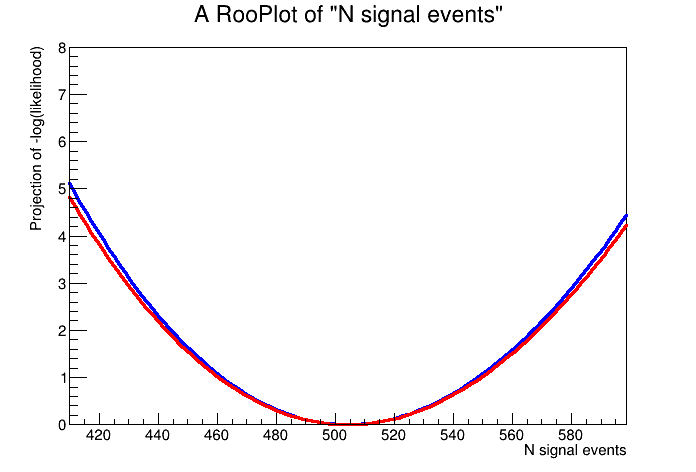

In [37]:
%%time

#'''
# Will profile over full var range, can take time. Set a relevant range.
N_sig.setRange(N_sig.getVal() - N_sig.getError()*3, N_sig.getVal() + N_sig.getError() * 3) 

frame_Nsig = N_sig.frame()

# Obtain NLL
#nll = R.RooNLLVar("nll", "nll", pdf, data)
nll = pdf.createNLL(data)
#R.RooMinimizer(nll).migrad() # minimize w.r.t. all vars
nll.plotOn(frame_Nsig, R.RooFit.ShiftToZero())

# Profile (takes some time as migrad calls are made at every step)
pNLL_Nsig = R.RooProfileLL("pNLL","pNLL", nll, N_sig)
profile_nll_sig = pNLL_Nsig.createProfile(N_sig)
profile_nll_sig.plotOn(frame_Nsig, R.RooFit.LineColor(R.kRed))

frame_Nsig.SetMinimum(0)
frame_Nsig.SetMaximum(8)
frame_Nsig.Draw()

c1.Draw()
#'''

When the difference in curves small, it implies that correlation between the parameters is small. That makes our life easy.  
(and maybe we can do without profiling)  

Another helpful theorem is `Wilk's theorem` which states that the underlying distribution of a test statistic of the form $-2 \log L(H_0)/L(H_1)$ approaches a $\chi^2$ distribution, under $H_0$.  
This effectively means we _know_ the underlying distribution of the test statistic already, and can easily find p-values for a DLL-like object.  
For instance, for 1 DOF the point that contains 68.3% of the area to the left (1$\sigma$, p-value 0.317) of $\chi^2(x)$ lies at x = 1 - so the negative likelihood ratio at 1/2.  
(However, Feldman-Cousins does not rely on this property).

## Implementation of FC

There are many implementations of frequentist procedures, such as `RooStats`, `GammaCombo` or `GammaPy`. However, for illustration we'll do it ourselves.  
The procedure is quite similar to what we've already seen, but now we also save the `DLL` values:

In [38]:
# Set the range back to 'normal'
N_sig.setRange(-15, 1000)

def fc_generate_and_fit( Nsig_gen ) :
    
    # set values for PDF parameters
    reset_pdf_vars() 
    N_bkg.setVal( N_bkg_val_true )  # from sideband fit
    expo_c.setVal( exp_c_val_true ) #  ''
    N_sig.setVal( Nsig_gen )        # set for generation

    # Generate signal and background
    toydata = pdf.generate(x, N_bkg_val_true + Nsig_gen)
    
    # Fit
    N_sig.setVal(0) 
    fitresult = pdf.fitTo(toydata, R.RooFit.Range("FULL"), R.RooFit.PrintLevel(-1), R.RooFit.Save())
    fitval = N_sig.getVal()
    #fitresult.Print()
    
    # Draw
    #frame = x.frame()
    #drawData(toydata)
    #drawPDF()
            
    # Obtain likelihood ratio values
    nll = pdf.createNLL(toydata)
    #R.RooMinimizer(nll).migrad()  
    
    ll_at_max = -nll.getVal()
    
    # set fitted parameter to 0 if < 0.
    if( N_sig.getVal() < 0 ) :
        N_sig.setVal(0) 
        ll_at_max = -nll.getVal()
            
    N_sig.setVal( Nsig_gen )  # Note: this is not profiling
    ll_at_true = -nll.getVal()
    
    dll = ll_at_max - ll_at_true
    
    return fitresult, fitval, dll

In [39]:
def fc_loop_generate_and_fit( Nsig_gen, N_iters, leavebar=True ) :

    fitval_array = []
    dll_array = []
    Nfailed = 0

    for i in tqdm(range(N_iters), leave=leavebar) :
        fitresult, fitval, dll = fc_generate_and_fit( Nsig_gen )
    
        if(fitresult.status() > 0) : 
            Nfailed += 1
            continue
        
        fitval_array += [fitval]
        dll_array += [dll]
    
    if(Nfailed > 0) : print("# failed fits: {0}".format(Nfailed))
    return fitval_array, dll_array

### Example

Let's make an example for `Nsig_gen = 10` and see what toying the DLL gives us

In [40]:
N_iters = 1000
Nsig_gen = 10

# build the 'underlying distribution' of dll with toys
fitval_array_10, dll_array_10 = fc_loop_generate_and_fit( Nsig_gen, N_iters, leavebar=False )

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's plot our findings: the distribution of "fitted `N_sig`" and the `dll` values.  
We can also "map out" the `dll` versus the fitted `N_sig` for every toy.

In [41]:
def fc_plot_toys(fitval_array, dll_array) :
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    fig.suptitle("Nsig_gen = {}".format(Nsig_gen))
    fig.set_figwidth(17)

    ax1.hist(fitval_array, bins=50)
    ax1.set_xlabel("Fitted Nsig")

    ax2.hist(dll_array, bins=50)
    ax2.set_xlabel("DLL");

    ax3.scatter(fitval_array, dll_array)
    ax3.set_xlabel("Fitted Nsig")
    ax3.set_ylabel("DLL");

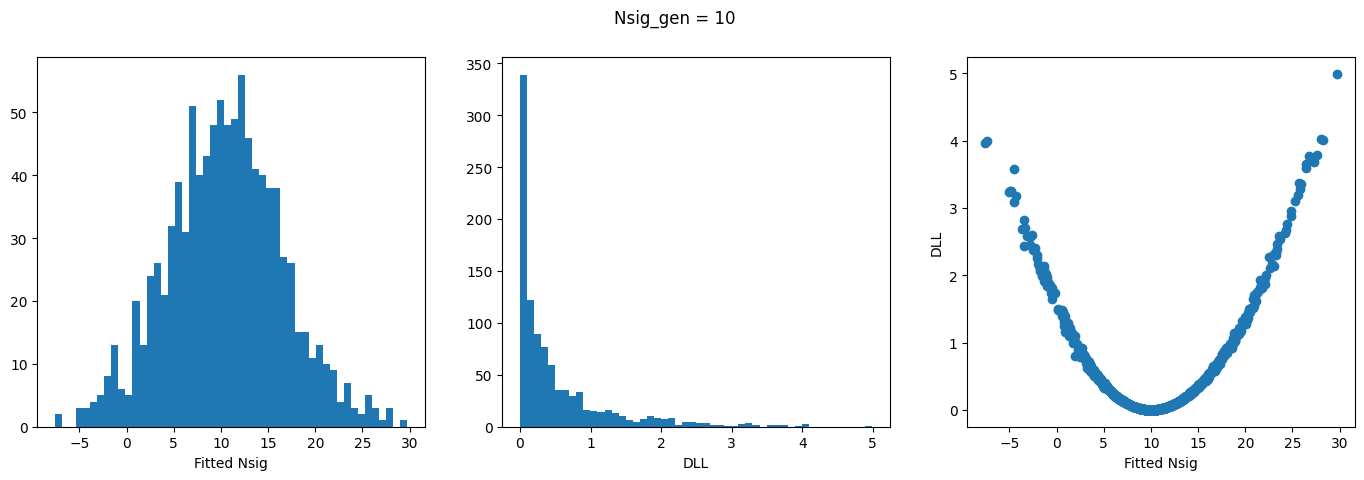

In [42]:
fc_plot_toys(fitval_array_10, dll_array_10)

The fitted `N_sig` looks nicely distributed around the generated value as before, reaching some natural negative values as well.  
If we plot the `dll` values themselves, they _should_ be distributed somewhat like a $\chi^2$ distribution.  
  
From the right plot, you can see how we can reach two-sided limits when moving from top to bottom, until we reach e.g. 10% of the total events (for a 90% CL).  
As we're now considering value pairs, we don't use the "bin-and-CDF" approach as above, but rather a sort.  

But what happens when we reach the physical boundary?  
Let's try to do the same for `Nsig_gen = 0`.  

In [43]:
N_iters = 1000
Nsig_gen = 0

fitval_array_0, dll_array_0 = fc_loop_generate_and_fit( Nsig_gen, N_iters, leavebar=False )

  0%|          | 0/1000 [00:00<?, ?it/s]

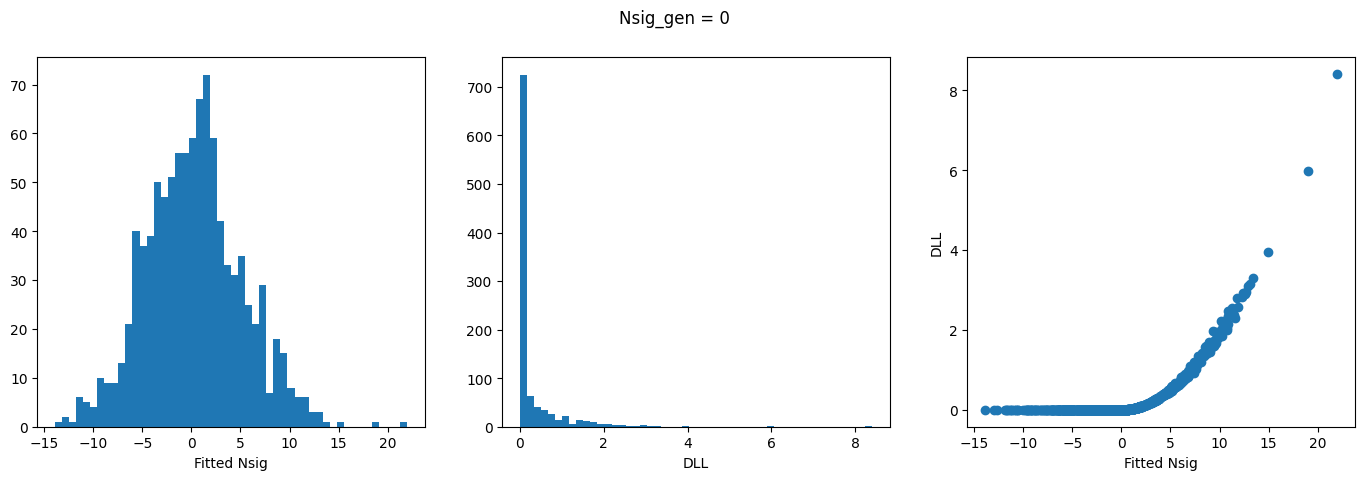

In [44]:
fc_plot_toys(fitval_array_0, dll_array_0)

By setting the fitted value to the generated value in case of unphysical fitresults,  
  before calculating the DLL by which we order our toy outcomes,  
  we create a natural one-sided "limit" behavior where the left side of the parabola goes down.  
  
If we now count events from the top downwards until we reach e.g. 10% of the events, we will only exclude events from the right.  
In fact, it has a natural smooth transition from 2-sided intervals to 1-sided limits.  
This is one of the other benefits of FC.  

Let's now try to write some code that actually finds these points.

In [45]:
def fc_get_CL_from_pairs( fitval_array, dll_array, CLval = 0.90, Nsample=25 ) :
    # Nsample is a stability parameter for averaging as we're sampling toys
    
    pairs = list(zip(fitval_array, dll_array))
    
    # sort by DLL
    sortedpairs = sorted( pairs, key = lambda x : x[1] )
    
    # Get the lowest point, to help figure out if we are dealing with a parabola (2-sided) or monotonic increasing function (upper limit)
    minDLLval = np.mean( [sortedpairs[i][0] for i in range(Nsample)] )
             
    # grab the index corresponding to CL% of the events
    CLi = int(CLval * len(sortedpairs))
    
    # sample some elements below it to find the min/max fitted Nsig values at the limit
    samplelist = sortedpairs[CLi - Nsample : CLi]
    fittedvals = [ s[0] for s in samplelist ]
    minmax = [ min(fittedvals), max(fittedvals) ]
    
    if( minmax[0] < minDLLval ) : return minmax
    else : return [0, minmax[1]]

In [46]:
CL_solution_10 = fc_get_CL_from_pairs( fitval_array_10, dll_array_10 )
print("FC 90% CL limits for Nsig_gen = 10: {}".format(CL_solution_10))

CL_solution_0 = fc_get_CL_from_pairs( fitval_array_0, dll_array_0 )
print("\nFC 90% CL limits for Nsig_gen = 0: {}".format(CL_solution_0))

FC 90% CL limits for Nsig_gen = 10: [0.5475411540676376, 20.546368202524036]

FC 90% CL limits for Nsig_gen = 0: [0, 7.029839386193881]


Now let's repeat this for all values of `Nsig_gen` and create the Neyman confidence belts.

In [47]:
N_iters = 200
Nsig_gen_range = np.arange(0, 30, 1)

CLvals_solutions = []
for Nsig_gen in tqdm(Nsig_gen_range) :
    
    # build the 'underlying distribution' of dll with toys
    fitval_array, dll_array = fc_loop_generate_and_fit( Nsig_gen, N_iters, leavebar=False )

    # obtain the values for the CL ordered by DLL
    CLvals_solutions += [fc_get_CL_from_pairs( fitval_array, dll_array )]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [48]:
# Transpose
CLvals_solutions = list(map(list, zip(*CLvals_solutions)))

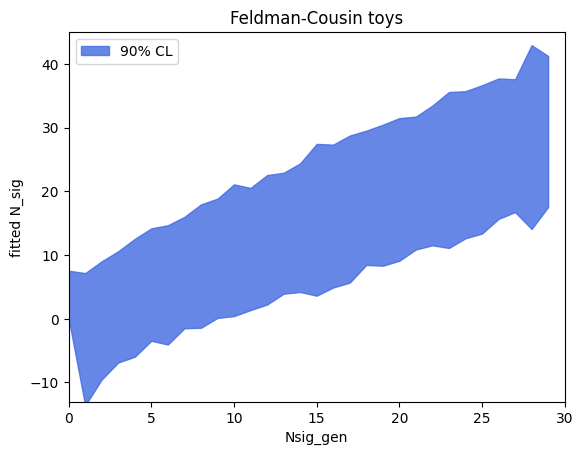

In [49]:
#plt.plot(Nsig_gen_range, CLvals_solutions[1], color="blue", linestyle="dashed")
plt.fill_between(Nsig_gen_range, CLvals_solutions[0], CLvals_solutions[1], alpha=0.8, color = "royalblue")
#plt.fill_betweenx(CLvals_solutions[0], CLvals_solutions[1], Nsig_gen_range, alpha=0.8, color = "royalblue")

plt.title("Feldman-Cousin toys")
plt.xlabel("Nsig_gen")
plt.ylabel("fitted N_sig")
plt.legend(["90% CL"], loc="upper left")
plt.xlim([0, 30])
plt.ylim([-13,45])
plt.show()

We want to interpret this plot as we did before:  
- When we fit `5` events, the lower side of the band starts at 0, and the 90% confidence interval is covered by the upper limit at a true value for `Nsig < 16`.  
- When we fit `12` events, the 90% CL matches the range [4,23] and naturally becomes a two-sided 90% interval.  

We now have a natural estimated upper limit for a full range of possible results.

<br/><br/>

## Unblinding

Now that we've made our sensitivity studies, let us "unblind" and fit our full dataset.

In [50]:
reset_pdf_vars()
fitresult = pdf.fitTo(real_data, R.RooFit.PrintLevel(-1), R.RooFit.Save())

fitresult.Print()

RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (1054.07) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	N_bkg=176.424	N_sig=-11.7095	expo_c=-0.00106745
RooNLLVar::nll_pdf_pdfData[ parameters=(N_bkg,N_sig,expo_c,mean,width) ]
     function value is NAN @ parameters=(N_bkg = 176.424 +/- 17.2538,N_sig = -11.7095 +/- 7.98587,expo_c = -0.00106745 +/- 0.000216741,mean = 5200 +/- 2.4051,width = 25 +/- 2.07233)
RooAddPdf::pdf[ N_sig * sig_pdf + N_bkg * bkg_pdf ]
     getLogVal() top-level p.d.f evaluates to a negative number @ !refCoefNorm=(), !pdfs=(sig_pdf = 0.0159241/62.6657,bkg_pdf = 0.000955709/4.07175), !coefficients=(N_sig = -11.7095 +/- 7.98587,N_bkg = 176.424 +/- 17.2538)
     getLogVal() top-level p.d.f evaluates to a negative number @ !refCoefNorm=(), !pdfs=(sig_pdf = 0.0149581/62.6657,bkg_pdf = 0.000944941/4.07175), !coefficients=(N_sig = -11.7095 +/- 7.98587,N_bkg = 176.424 +/- 17.2538)
     getLogVal() top-

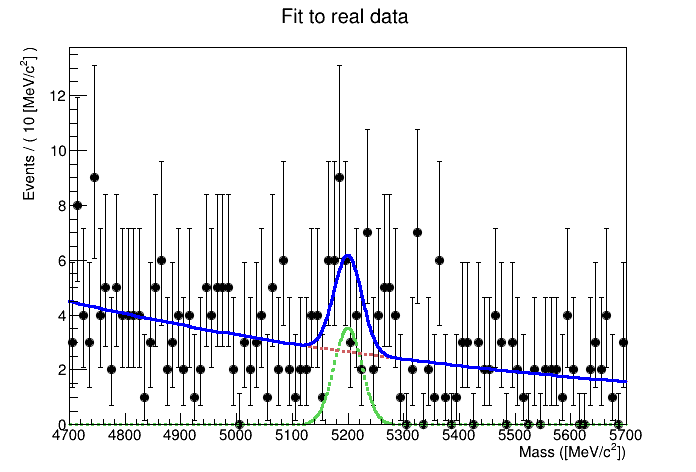

In [51]:
frame = x.frame()
frame.SetTitle("Fit to real data")
drawData(real_data)
drawPDF()

In [52]:
fittedsig, fittederr = N_sig.getVal(), N_sig.getError()

print("N_sig = {:.2f} +- {:.2f}".format(fittedsig, fittederr))
print("Significance: {:.1f} sigma".format( fittedsig / fittederr ))

N_sig = 22.11 +- 7.27
Significance: 3.0 sigma


Let's scan the likelihood of our real observation.

In [59]:
nll = pdf.createNLL(real_data)
#R.RooMinimizer(nll).migrad()  
#ll_at_max = -nll.getVal()
N_sig.setVal(0)
ll_at_0 = -nll.getVal()

Nsig_range = np.arange(0, 40, 1)
dll_true_array = []
for Nsig in Nsig_range :
    
    N_sig.setVal(Nsig)
    ll_at_val = -nll.getVal()

    #dll = ll_at_max - ll_at_val
    dll = ll_at_0 - ll_at_val
    dll_true_array += [dll]

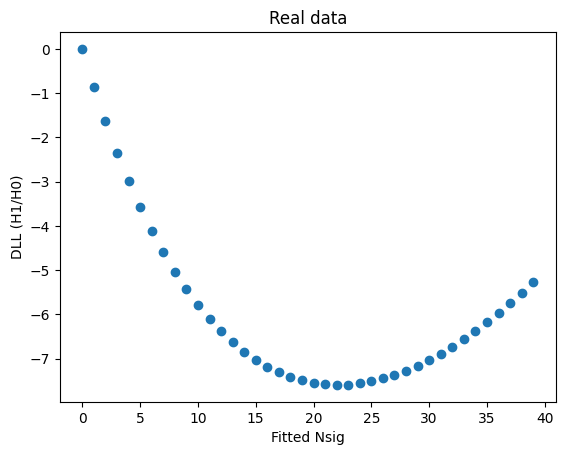

In [60]:
plt.scatter(Nsig_range, dll_true_array)
plt.xlabel("Fitted Nsig")
plt.ylabel("DLL (H1/H0)")
plt.title("Real data");

### Sensitivity vs limits

Sensitivity = average of upper limits obtained from toys. Compared to upper limits which are "X% of repeated measurements will fall in this region".   
"small number paradox" - experiments with higher bkg can seemingly set tighter limits when observing 0 events, which should not be.

### FC vs CLs

Another (quasi-)frequentist approach to limit setting is the so-called `CLs` method.